In [1]:
import torch
from torch import nn

import sys
import os
path = os.path.abspath("Helpers")
sys.path.append(path)
from helper_functions import plot_predictions, plot_decision_boundary, accuracy_fn

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from timeit import default_timer as timer
from tqdm.auto import tqdm 

c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
if image_path.is_dir():
    print(f"{image_path} already exists")
else:
    print(f"{image_path} does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download the data
with open(data_path/"pizaa_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading the data")
    f.write(request.content)
    f.close()

with zipfile.ZipFile(data_path/"pizaa_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping data...")
    zip_ref.extractall(image_path)

data\pizza_steak_sushi already exists
Unzipping data...


In [4]:
import os

def walk_through_dir(dir_path):
    for dirpath, dirname, filenams in os.walk(dir_path):
        print(f"There are {len(dirname)} directories and {len(filenams)} images in {dirpath}")

walk_through_dir(image_path)

There are 2 directories and 0 images in data\pizza_steak_sushi
There are 3 directories and 0 images in data\pizza_steak_sushi\test
There are 0 directories and 25 images in data\pizza_steak_sushi\test\pizza
There are 0 directories and 19 images in data\pizza_steak_sushi\test\steak
There are 0 directories and 31 images in data\pizza_steak_sushi\test\sushi
There are 3 directories and 0 images in data\pizza_steak_sushi\train
There are 0 directories and 78 images in data\pizza_steak_sushi\train\pizza
There are 0 directories and 75 images in data\pizza_steak_sushi\train\steak
There are 0 directories and 72 images in data\pizza_steak_sushi\train\sushi


In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [7]:
import random
from PIL import Image

image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2218680.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2236338.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2508636.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2871261.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/3092704.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/309892.jp

In [8]:

# random.seed(42)
random_image_path = random.choice(image_path_list)
# random_image_path
image_class = random_image_path.parent.stem
# print(image_class)
img = Image.open(random_image_path)
print(f"Random image path : {random_image_path}")
print(f"Image class : {image_class}")
print(f"Image height : {img.height}")
print(f"Image width : {img.width}")



Random image path : data\pizza_steak_sushi\train\pizza\1524655.jpg
Image class : pizza
Image height : 512
Image width : 512


(512, 512, 3)


Text(0.5, 1.0, 'pizza')

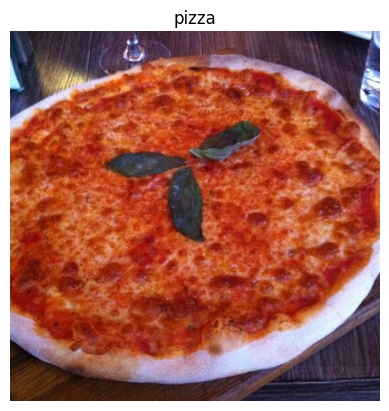

In [9]:
import numpy as np

img_array = np.array(img)
print(img_array.shape)
plt.imshow(img_array)
plt.axis(False)
plt.title(image_class)

In [10]:
print(img_array)

[[[ 20  40  51]
  [ 26  46  57]
  [ 30  47  63]
  ...
  [154 174 237]
  [166 184 248]
  [167 185 249]]

 [[ 10  30  41]
  [ 20  40  51]
  [ 24  41  57]
  ...
  [155 175 238]
  [168 186 250]
  [170 188 252]]

 [[ 11  29  41]
  [ 21  39  51]
  [ 18  35  51]
  ...
  [157 175 237]
  [168 183 248]
  [170 185 250]]

 ...

 [[ 37  20  10]
  [ 45  29  16]
  [ 49  33  20]
  ...
  [ 44  45  75]
  [ 35  36  66]
  [ 25  26  56]]

 [[ 29  15   6]
  [ 42  28  17]
  [ 55  38  28]
  ...
  [ 42  46  75]
  [ 35  39  68]
  [ 33  37  66]]

 [[ 39  25  16]
  [ 44  30  21]
  [ 47  30  20]
  ...
  [ 44  48  77]
  [ 39  43  72]
  [ 46  50  79]]]


Transforming Data

In [11]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

tImg = data_transform(img)





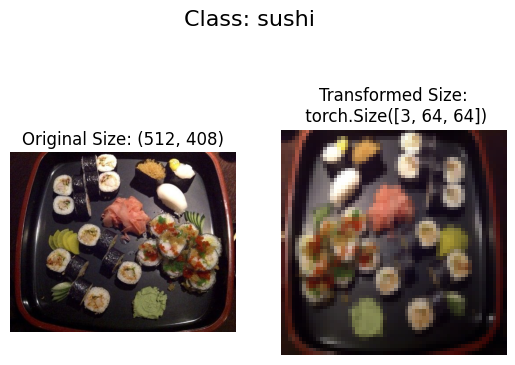

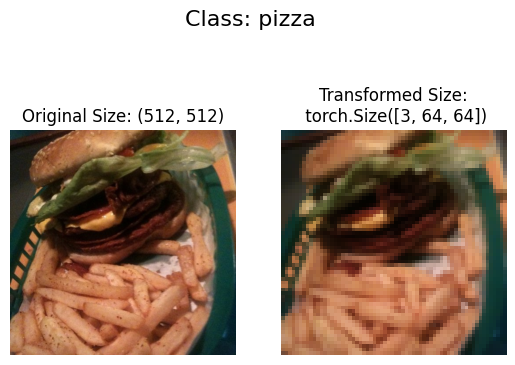

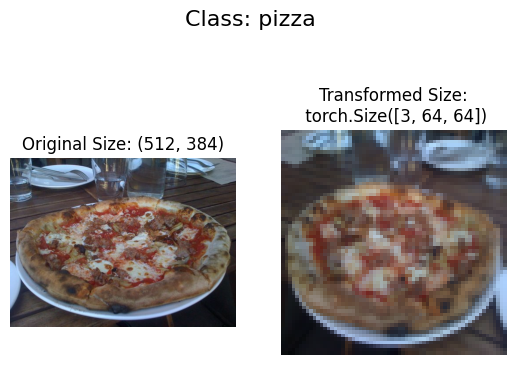

In [12]:
def plot_transformed_images(image_paths, transform, n = 3, seed = 42):
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k = n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows = 1, ncols = 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original Size: {f.size}")
            ax[0].axis(False)

            transformed_image = transform(f)
            ax[1].imshow(transformed_image.permute(1, 2, 0))
            ax[1].set_title(f"Transformed Size:\n {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)
plot_transformed_images(image_paths=image_path_list, transform=data_transform)


Option 1:


In [13]:
train_data = datasets.ImageFolder(root = train_dir, transform = data_transform, target_transform=None)
test_data = datasets.ImageFolder(root = test_dir, transform = data_transform, target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

(-0.5, 63.5, 63.5, -0.5)

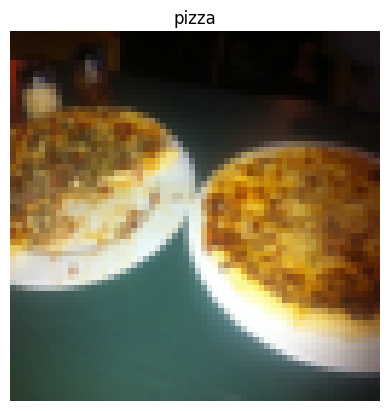

In [14]:
class_names = train_data.classes
class_dict = train_data.class_to_idx
class_dict
len(train_data.samples), len(train_data.targets)
img, label = train_data[0][0], train_data[0][1]
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [15]:
BATCH_SIZE = 16
train_dataloader = DataLoader(dataset = train_data,
                               batch_size=BATCH_SIZE,
                               num_workers=1,
                               shuffle=True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE, 
                             num_workers=1,
                             shuffle = False)

In [16]:
print(train_dataloader.dataset[133][1])

1


Option 2:


In [17]:
import os
import pathlib
import torch
from torch.utils.data.dataset import Dataset
from PIL import Image
from torchvision import transforms
from typing import Tuple, Dict, List

def findClasses(directory):
    classes = sorted(entry.name for entry in list(os.scandir(directory)))
    
    indexLabel = {val:index for index, val in enumerate(classes)} 
    
    if not classes:
        raise FileNotFoundError(f"Clould not find classes in {directory}... Please check file directory")
    return classes, indexLabel

class ImageFolderCustom(Dataset):
    def __init__(self, targ_dir, transform = None):
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # Set up transform
        self.transform = transform
        # Create classes and class_to_index attributes
        self.classes, self.class_to_idx = findClasses(targ_dir)

    # Function to load an image by index
    def loadImage(self, idx):
        image_path = self.paths[idx]
        return Image.open(image_path)

    # Overwrite __len__()
    def __len__(self):
        return len(self.paths) 
    
    # Overwrite __getItem__() method to return a particular sample
    def __getitem__(self, index):
        img = self.loadImage(index)
        class_name = self.paths[index].parent.name #Expects path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [18]:
train_transforms = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.ToTensor()
])

In [19]:
train_data_custom = ImageFolderCustom(targ_dir = train_dir, transform = train_transforms)
test_data_custom = ImageFolderCustom(targ_dir = test_dir, transform = test_transforms) 
train_data.classes == train_data_custom.classes, test_data.class_to_idx == test_data_custom.class_to_idx

(True, True)

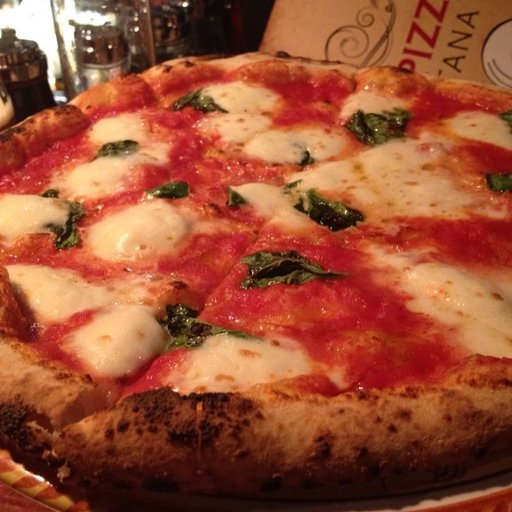

In [20]:
train_data_custom.loadImage(1)

In [21]:
def display_random_images(dataset, classes, n, display_shape = True, seed = None):
    if n > 10:
        display_shape = False
        print(f"For display purposes, n should be less than 11")
    
    if seed:
        see = random.seed(seed)

    random_sample_idx = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize = (16, 8))
    for i, targ_sample in enumerate(random_sample_idx):
        img, label = dataset[targ_sample]
        img = img.permute(1, 2, 0)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis(False)
        if classes:
            title = f"Class: {classes[label]}"
            # if display_shape:
                # title = title + f"\nshape: {img.shape}"
        plt.title(title)
    

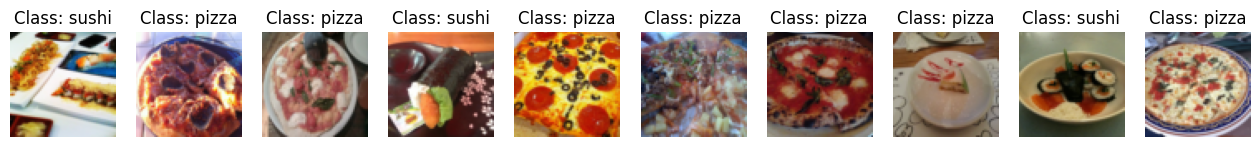

In [22]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=10, 
                      classes=class_names,
                      seed=42)

In [23]:
custom_train_dataset_loader = DataLoader(dataset = train_data_custom,
                               batch_size=BATCH_SIZE,
                               num_workers=1,
                               shuffle=True)
custom_test_dataset_loader = DataLoader(dataset = test_data_custom,
                               batch_size=BATCH_SIZE,
                               num_workers=1,
                               shuffle=True)

In [25]:
custom_test_dataset_loader,custom_train_dataset_loader
print(custom_test_dataset_loader.dataset[0])



(tensor([[[0.0471, 0.2039, 0.3725,  ..., 0.0824, 0.1333, 0.1020],
         [0.2000, 0.1961, 0.2667,  ..., 0.0784, 0.1255, 0.1137],
         [0.0980, 0.1176, 0.1333,  ..., 0.1059, 0.1255, 0.1255],
         ...,
         [0.0196, 0.0196, 0.0235,  ..., 0.0863, 0.1059, 0.0980],
         [0.0196, 0.0235, 0.0235,  ..., 0.0863, 0.1020, 0.0941],
         [0.0196, 0.0196, 0.0235,  ..., 0.0980, 0.0980, 0.0863]],

        [[0.0196, 0.1255, 0.2471,  ..., 0.0235, 0.0353, 0.0235],
         [0.1333, 0.1216, 0.1608,  ..., 0.0157, 0.0275, 0.0235],
         [0.0588, 0.0667, 0.0784,  ..., 0.0314, 0.0196, 0.0235],
         ...,
         [0.0039, 0.0039, 0.0078,  ..., 0.0196, 0.0235, 0.0196],
         [0.0039, 0.0078, 0.0078,  ..., 0.0196, 0.0235, 0.0196],
         [0.0039, 0.0039, 0.0078,  ..., 0.0314, 0.0235, 0.0196]],

        [[0.0118, 0.0392, 0.0588,  ..., 0.0039, 0.0078, 0.0039],
         [0.0510, 0.0314, 0.0431,  ..., 0.0039, 0.0078, 0.0039],
         [0.0275, 0.0353, 0.0353,  ..., 0.0196, 0.0078, 0